## Imports



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

# Tratamento

#### 2019

In [2]:
chunksize = 10000
chunks = pd.read_csv(
    'MICRODADOS_ENEM_2019.csv',
    chunksize=chunksize,
    on_bad_lines='skip',
    encoding='latin1',
    delimiter=";"
)

df_raw = pd.concat(chunks)

In [65]:
colunas_interesse = [
    'NU_INSCRICAO', 'TP_SEXO', 'TP_COR_RACA', 'SG_UF_ESC', 
    'TP_ESCOLA', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 
    'TP_STATUS_REDACAO',
    'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'SG_UF_PROVA', 
    'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_MUNICIPIO_ESC','NO_MUNICIPIO_ESC',
]

In [ ]:
df = df_raw[colunas_interesse]
df['MUNICIPIO'] = np.where(
    df['NO_MUNICIPIO_ESC'].isna() | (df['NO_MUNICIPIO_ESC'] == ""),
    df['NO_MUNICIPIO_PROVA'],
    df['NO_MUNICIPIO_ESC']
)


df['UF'] = np.where(
    df['SG_UF_ESC'].isna() | (df['SG_UF_ESC'] == ""),
    df['SG_UF_PROVA'],
    df['SG_UF_ESC']
)


In [ ]:
df = df[
  (df['UF'] == 'CE')
   ]


In [68]:
df['Tem_Computador'] = np.where(df['Q024'] == 'A', 0, 1) 
df['Tem_Internet'] = np.where(df['Q025'] == 'A', 0, 1) 
df['Alta_Estrutura'] = np.where(df['TP_DEPENDENCIA_ADM_ESC'].isin([1,4]), 1, 0)
df['Inclusao_Digital_Plena'] = df['Tem_Computador'] * df['Tem_Internet']
df['NU_NOTA_GERAL'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT'] + df['NU_NOTA_REDACAO']) / 5
# df = df.dropna(subset=['NU_NOTA_GERAL'])

In [69]:
print(len(df))
df = df[
  (df['TP_PRESENCA_CH'] * df['TP_PRESENCA_LC'] * df['TP_PRESENCA_CN'] * df['TP_PRESENCA_MT']) == 1 
]
print(len(df))


295448
221655


In [70]:
df_indicadores_mun = df.groupby('MUNICIPIO').agg(
    Total_Alunos=('Inclusao_Digital_Plena', 'count'),
    Total_Inclusao_Digital=('Inclusao_Digital_Plena', 'sum'),
    Taxa_Inclusao_Digital=('Inclusao_Digital_Plena', 'mean'),
    Internet =('Tem_Internet', 'sum'),
    Taxa_Internet=('Tem_Internet', 'mean'),
    Computador =('Tem_Computador', 'sum'),
    Taxa_Computador=('Tem_Computador', 'mean'),
    Nota_Redacao=('NU_NOTA_REDACAO', 'mean'),
    Nota_CH=('NU_NOTA_CH', 'mean'),
    Nota_Mat=('NU_NOTA_MT', 'mean'),
    Nota_LC=('NU_NOTA_LC', 'mean'),
    Nota_CN=('NU_NOTA_CN', 'mean'),
    Nota_Media_Geral=('NU_NOTA_GERAL', 'mean')
).reset_index()
df_indicadores_mun['Taxa_Alunos'] = df_indicadores_mun['Total_Alunos'] / df_indicadores_mun['Total_Alunos'].sum()
# df_indicadores_mun['Nenhum'] = df_indicadores_mun['Total_Alunos'] - (df_indicadores_mun['Internet'] + df_indicadores_mun['Computador'] - df_indicadores_mun['Total_Inclusao_Digital'])
# df_indicadores_mun['Taxa Nenhum'] = df_indicadores_mun['Nenhum'] / df_indicadores_mun['Total_Alunos']

#### 2024

In [73]:
# chunksize = 10000
# chunks = pd.read_csv(
#     'RESULTADOS_2023.csv',
#     chunksize=chunksize,
#     on_bad_lines='skip',
#     encoding='latin1',
#     delimiter=";"
# )

chunksize = 10000
chunks = pd.read_csv(
    'MICRODADOS_ENEM_2023.csv',
    chunksize=chunksize,
    on_bad_lines='skip',
    encoding='latin1',
    delimiter=";"
)



# alunos23 = pd.concat(chunks)
df23 = pd.concat(chunks)

In [74]:
df23['MUNICIPIO'] = np.where(
    df23['NO_MUNICIPIO_ESC'].isna() | (df23['NO_MUNICIPIO_ESC'] == ""),
    df23['NO_MUNICIPIO_PROVA'],
    df23['NO_MUNICIPIO_ESC']
)

df23['UF'] = np.where(
    df23['SG_UF_ESC'].isna() | (df23['SG_UF_ESC'] == ""),
    df23['SG_UF_PROVA'],
    df23['SG_UF_ESC']
)

In [75]:

# alunos23 = alunos23[alunos23['SG_UF_PROVA'] == 'CE']
df23 = df23[df23['UF'] == 'CE']
# alunos23 = alunos23.rename(columns={'Q020': 'Internet', 'Q021': 'Computador'})
df23 = df23.rename(columns={'Q025': 'Internet', 'Q024': 'Computador'})
# df23['Alta_Estrutura'] = np.where(df23['TP_DEPENDENCIA_ADM_ESC'].isin([1,4]), 1, 0)
# alunos23['Tem_Computador'] = np.where(alunos23['Computador'] == 'A', 0, 1) 
# alunos23['Tem_Internet'] = np.where(alunos23['Internet'] == 'A', 0, 1) 
# alunos23['Inclusao_Digital_Plena'] = alunos23['Tem_Computador'] * alunos23['Tem_Internet']
df23['Tem_Computador'] = np.where(df23['Computador'] == 'A', 0, 1) 
df23['Tem_Internet'] = np.where(df23['Internet'] == 'A', 0, 1) 
df23['Inclusao_Digital_Plena'] = df23['Tem_Computador'] * df23['Tem_Internet']

df23['Nota_Media_Geral'] = (df23['NU_NOTA_CH'] + df23['NU_NOTA_CN'] + df23['NU_NOTA_LC']  + df23['NU_NOTA_MT'] + df23['NU_NOTA_REDACAO']) / 5

# df23 = df23.dropna(subset=['Nota_Media_Geral'])

In [76]:
print(len(df23))
df23 = df23[
  (df23['TP_PRESENCA_CH'] * df23['TP_PRESENCA_LC'] * df23['TP_PRESENCA_CN'] * df23['TP_PRESENCA_MT']) == 1 
]
print(len(df23))

242421
174003


In [78]:
df_indicadores_mun23 = df23.groupby('MUNICIPIO').agg(
    Nota_Redacao=('NU_NOTA_REDACAO', 'mean'),
    Nota_CH=('NU_NOTA_CH', 'mean'),
    Nota_Mat=('NU_NOTA_MT', 'mean'),
    Nota_LC=('NU_NOTA_LC', 'mean'),
    Nota_CN=('NU_NOTA_CN', 'mean'),
    Nota_Media_Geral=('Nota_Media_Geral', 'mean'),
    Total_Inclusao_Digital=('Inclusao_Digital_Plena', 'sum'),
    Taxa_Inclusao_Digital=('Inclusao_Digital_Plena', 'mean'),
    Internet =('Tem_Internet', 'sum'),
    Taxa_Internet=('Tem_Internet', 'mean'),
    Computador =('Tem_Computador', 'sum'),
    Taxa_Computador=('Tem_Computador', 'mean'),
    Total_Alunos=('NU_INSCRICAO', 'count')
)

df_indicadores_mun23['Taxa_Alunos'] = df_indicadores_mun23['Total_Alunos'] / df_indicadores_mun23['Total_Alunos'].sum()
df_indicadores_mun23 = df_indicadores_mun23.sort_values(by=['Taxa_Inclusao_Digital'], ascending=False).reset_index()


In [ ]:
# alunos_agrupado2024 = alunos24[['Inclusao_Digital_Plena', 'Tem_Computador', 'Tem_Internet', 'NO_MUNICIPIO_PROVA']].groupby('NO_MUNICIPIO_PROVA').agg(
#     Total_Alunos=('Inclusao_Digital_Plena', 'count'),
#     Total_Inclusao_Digital=('Inclusao_Digital_Plena', 'sum'),
#     Taxa_Inclusao_Digital=('Inclusao_Digital_Plena', 'mean'),
#     Internet =('Tem_Internet', 'sum'),
#     Taxa_Internet=('Tem_Internet', 'mean'),
#     Computador =('Tem_Computador', 'sum'),
#     Taxa_Computador=('Tem_Computador', 'mean')).reset_index().sort_values(by=['Taxa_Inclusao_Digital'], ascending=False)
# alunos_agrupado2024['Taxa_Alunos'] = alunos_agrupado2024['Total_Alunos'] / alunos_agrupado2024['Total_Alunos'].sum()

# df24_agrupado = df24.groupby('NO_MUNICIPIO_PROVA').agg(
#     Total_Alunos=('NU_SEQUENCIAL', 'count'),
#     Nota_Redacao=('NU_NOTA_REDACAO', 'mean'),
#     Nota_CH=('NU_NOTA_CH', 'mean'),
#     Nota_Mat=('NU_NOTA_MT', 'mean'),
#     Nota_LC=('NU_NOTA_LC', 'mean'),
#     Nota_CN=('NU_NOTA_CN', 'mean'),
#     Nota_Media_Geral=('Nota_Media_Geral', 'mean')

# ).reset_index().sort_values(by=['Nota_Media_Geral'], ascending=False)

# df_indicadores_mun24 = pd.merge(df24_agrupado.drop('Total_Alunos', axis=1), alunos_agrupado2024, on='NO_MUNICIPIO_PROVA', how='inner')

In [79]:
total_alunos = df_indicadores_mun['Total_Alunos'].sum()
total_inclusao = df_indicadores_mun['Total_Inclusao_Digital'].sum()
total_internet =  df_indicadores_mun['Internet'].sum()
total_comp =  df_indicadores_mun['Computador'].sum()

print(f"Total de Alunos presentes: {total_alunos}")
print(f"Total com Inclusão Digital Plena: {total_inclusao}")
print(f"Total com Internet: {total_internet}")
print(f"Total com Computador(es): {total_comp}")


Total de Alunos presentes: 221655
Total com Inclusão Digital Plena: 79032
Total com Internet: 151605
Total com Computador(es): 83359


In [80]:
total_alunos = df_indicadores_mun23['Total_Alunos'].sum()
total_inclusao = df_indicadores_mun23['Total_Inclusao_Digital'].sum()
total_internet =  df_indicadores_mun23['Internet'].sum()
total_comp =  df_indicadores_mun23['Computador'].sum()

print(f"Total de Alunos: {total_alunos}")
print(f"Total com Inclusão Digital Plena: {total_inclusao}")
print(f"Total com Internet: {total_internet}")
print(f"Total com Computador(es): {total_comp}")

Total de Alunos: 174003
Total com Inclusão Digital Plena: 54927
Total com Internet: 151268
Total com Computador(es): 55664


In [85]:
len(df_indicadores_mun23)

184

In [81]:
display(df_indicadores_mun[['Nota_Media_Geral', 'Taxa_Computador', 'Taxa_Internet', 'Taxa_Inclusao_Digital']].corr().sort_values(by=['Nota_Media_Geral'], ascending=False))

,Nota_Media_Geral,Taxa_Computador,Taxa_Internet,Taxa_Inclusao_Digital
Nota_Media_Geral,1.000000,0.731715,0.437169,0.716505
Taxa_Computador,0.731715,1.000000,0.762201,0.994883
Taxa_Inclusao_Digital,0.716505,0.994883,0.778540,1.000000
Taxa_Internet,0.437169,0.762201,1.000000,0.778540


In [82]:
display(df_indicadores_mun23[['Nota_Media_Geral', 'Taxa_Computador', 'Taxa_Internet', 'Taxa_Inclusao_Digital']].corr().sort_values(by=['Nota_Media_Geral'], ascending=False))

,Nota_Media_Geral,Taxa_Computador,Taxa_Internet,Taxa_Inclusao_Digital
Nota_Media_Geral,1.000000,0.784792,0.149695,0.787983
Taxa_Inclusao_Digital,0.787983,0.995791,0.293631,1.000000
Taxa_Computador,0.784792,1.000000,0.272755,0.995791
Taxa_Internet,0.149695,0.272755,1.000000,0.293631


# 2019

## Análise

In [ ]:
df_indicadores_mun.describe()

,Total_Alunos,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Taxa_Alunos
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,1859.697479,662.941176,0.259580,1271.621849,0.600723,699.294118,0.278765,542.493910,483.340367,500.259397,499.307711,453.247453,495.729768,0.008403
std,6520.804100,3187.010299,0.080211,5221.106581,0.125312,3304.509470,0.081407,32.402302,10.801298,13.913434,9.924569,10.503141,14.290967,0.029465
min,262.000000,23.000000,0.065156,70.000000,0.198300,23.000000,0.065156,438.366013,462.599550,473.695721,478.219790,431.402477,462.716405,0.001184
25%,588.500000,147.500000,0.211993,378.000000,0.534624,158.500000,0.229397,522.057833,476.679970,490.559412,492.753955,445.992654,485.504708,0.002659
50%,980.000000,218.000000,0.251521,506.000000,0.608878,241.000000,0.272194,538.396334,481.608168,498.646544,498.284283,451.649696,494.109425,0.004428
75%,1440.500000,391.500000,0.301988,887.000000,0.684885,419.500000,0.318882,562.796041,488.993793,508.993822,505.079742,458.856319,504.512134,0.006509
max,71173.000000,34669.000000,0.487109,56844.000000,0.801020,35946.000000,0.505051,619.435594,523.902734,543.529739,533.426242,489.605600,541.059775,0.321607


### Análise Univariada da nota média

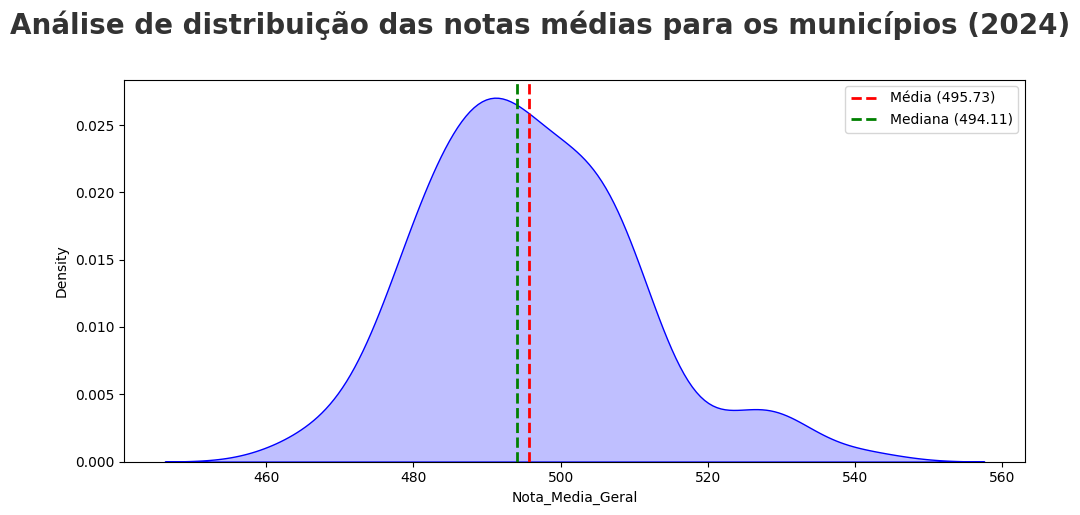

Média: 495.7297677870896
Mediana: 494.1094252873563
Skew: 0.5554192012935013


In [19]:
plt.figure(figsize=(10, 5))
plt.suptitle(
    "Análise de distribuição das notas médias para os municípios (2024)",
    fontsize=20,
    fontweight='bold',
    alpha=0.8,
    y=1.02
)

# KDE plot
sns.kdeplot(
    data=df_indicadores_mun,
    x='Nota_Media_Geral',
    fill=True,
    color='blue'
)

# Calculando média e mediana
media = df_indicadores_mun['Nota_Media_Geral'].mean()
mediana = df_indicadores_mun['Nota_Media_Geral'].median()
skew = df_indicadores_mun['Nota_Media_Geral'].skew()

# Linhas verticais
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média ({media:.2f})")
plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f"Mediana ({mediana:.2f})")

# Legenda
plt.legend()

plt.tight_layout()
plt.show()

print(f"Média: {media}")
print(f"Mediana: {mediana}")
print(f"Skew: {skew}")

> A nota média se concentra entre 490 e 500

### Análise Univariada da gestão digital

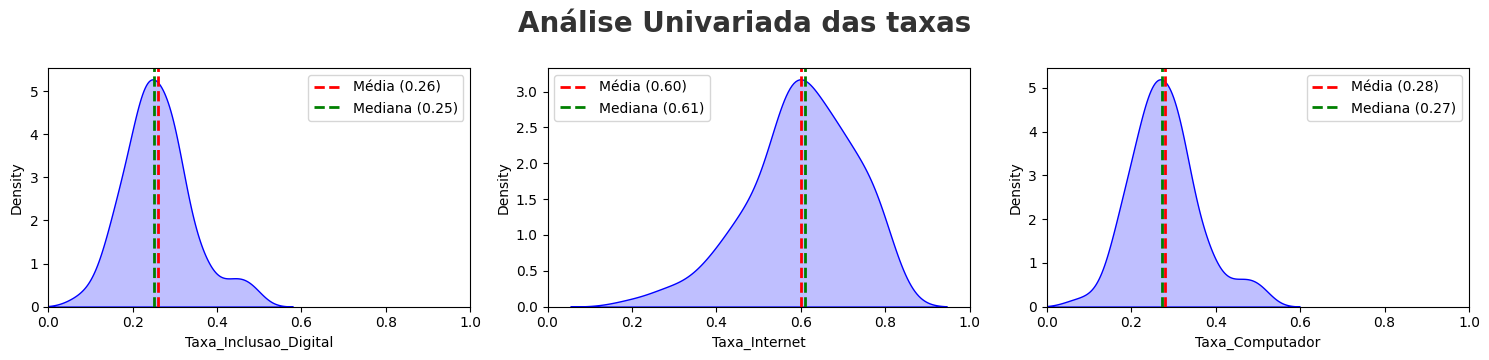

In [20]:
plt.figure(figsize=(15, 15))
plt.suptitle("Análise Univariada das taxas", fontsize=20, fontweight='bold', alpha=0.8, y=1.0)

numeric_features = ['Taxa_Inclusao_Digital', 'Taxa_Internet', 'Taxa_Computador']

for i in range(len(numeric_features)):
    # 1. PRIMEIRO ative o subplot correto
    plt.subplot(5, 3, i+1)
    
    # 2. Desenhe o gráfico principal (KDE)
    sns.kdeplot(data=df_indicadores_mun, x=numeric_features[i], fill=True, color='blue')
    
    # 3. Calcule as estatísticas
    media = df_indicadores_mun[numeric_features[i]].mean()
    mediana = df_indicadores_mun[numeric_features[i]].median()
    
    # 4. AGORA desenhe as linhas (elas vão aparecer no subplot ativo acima)
    plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média ({media:.2f})")
    plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f"Mediana ({mediana:.2f})")
    
    # Configurações adicionais
    plt.xlabel(numeric_features[i])
    plt.xlim(0, 1)
    plt.legend() # Adicionei para mostrar as labels da média/mediana

plt.tight_layout()
plt.show()

> A distribuição de probabilidade aponta para um cenário ruim tanto na taxa de inclusão digital quanto na taxa_computador. O que significa dizer que existe um inclusão digital "parcial", mais voltada à conectividade do que a dispositivos. O que no cenário educacional prejudica mais os alunos, pois ter internet sem um dispositivo adequado não ajuda no desempenho dos mesmos.

> A taxa de inclusão digital tem uma média entre 26% apenas entre os municípios

## Análise Bivariada

### Matriz de Correlação

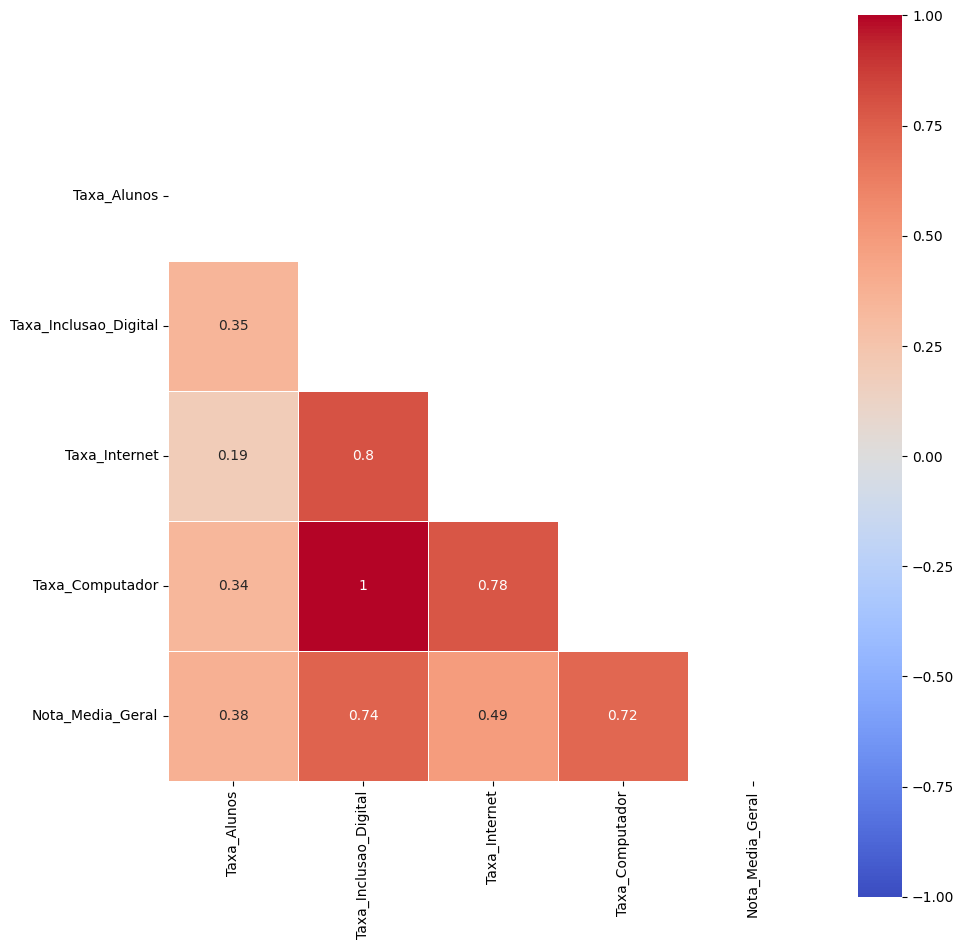

In [22]:
correlations = df_indicadores_mun[['Taxa_Alunos','Taxa_Inclusao_Digital','Taxa_Internet', 'Taxa_Computador', 'Nota_Media_Geral']].corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))
plt.figure(figsize=(10,10))
sns.heatmap(correlations, 
            annot=True,
            mask=mask,
            cmap='coolwarm',  
            square=True, 
            linewidths=.5, 
            cbar=True, 
            vmin=-1, 
            vmax=1)

plt.tight_layout()

# Mostre o heatmap
plt.show()

> A "Inclusão Digital" não é travada pela falta de cabos ou conectividade, mas sim pela falta do dispositivos. A política pública deveria focar em hardware, pois a conectividade já parece acompanhar quem tem o hardware. Basicamente, acesso a internet sem o dispotivo adequado (um celular não é o suficiente) não ajuda tanto assim.

# 2024

### Analise de distribuição da nota média

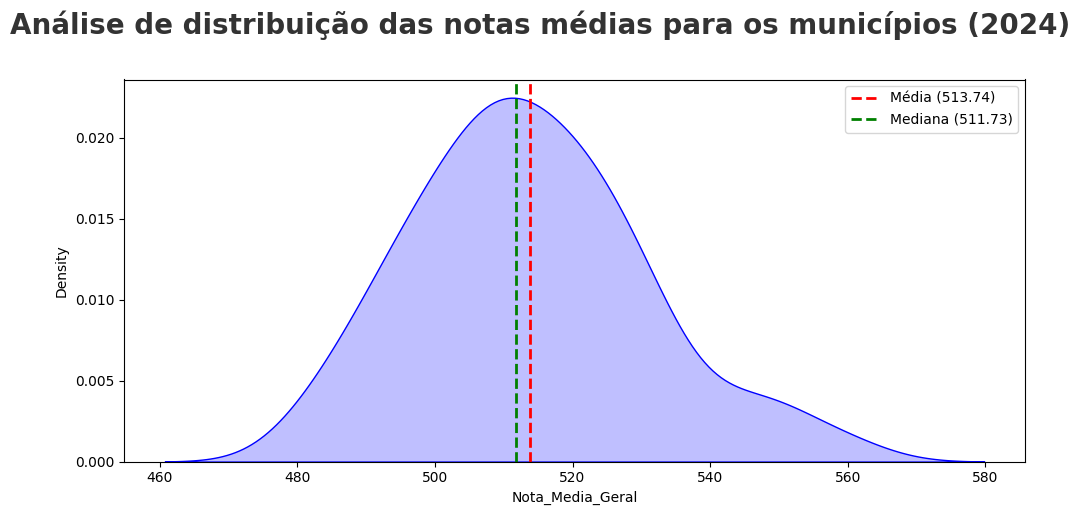

Média: 513.7424981829229
Mediana: 511.7280031721991


In [48]:
plt.figure(figsize=(10, 5))
plt.suptitle(
    "Análise de distribuição das notas médias para os municípios (2024)",
    fontsize=20,
    fontweight='bold',
    alpha=0.8,
    y=1.02
)

# KDE plot
sns.kdeplot(
    data=df_indicadores_mun24,
    x='Nota_Media_Geral',
    fill=True,
    color='blue'
)

# Calculando média e mediana
media = df_indicadores_mun24['Nota_Media_Geral'].mean()
mediana = df_indicadores_mun24['Nota_Media_Geral'].median()

# Linhas verticais
plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f"Média ({media:.2f})")
plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f"Mediana ({mediana:.2f})")

# Legenda
plt.legend()

plt.tight_layout()
plt.show()

print(f"Média: {media}")
print(f"Mediana: {mediana}")


### Análise de distribuição das taxas

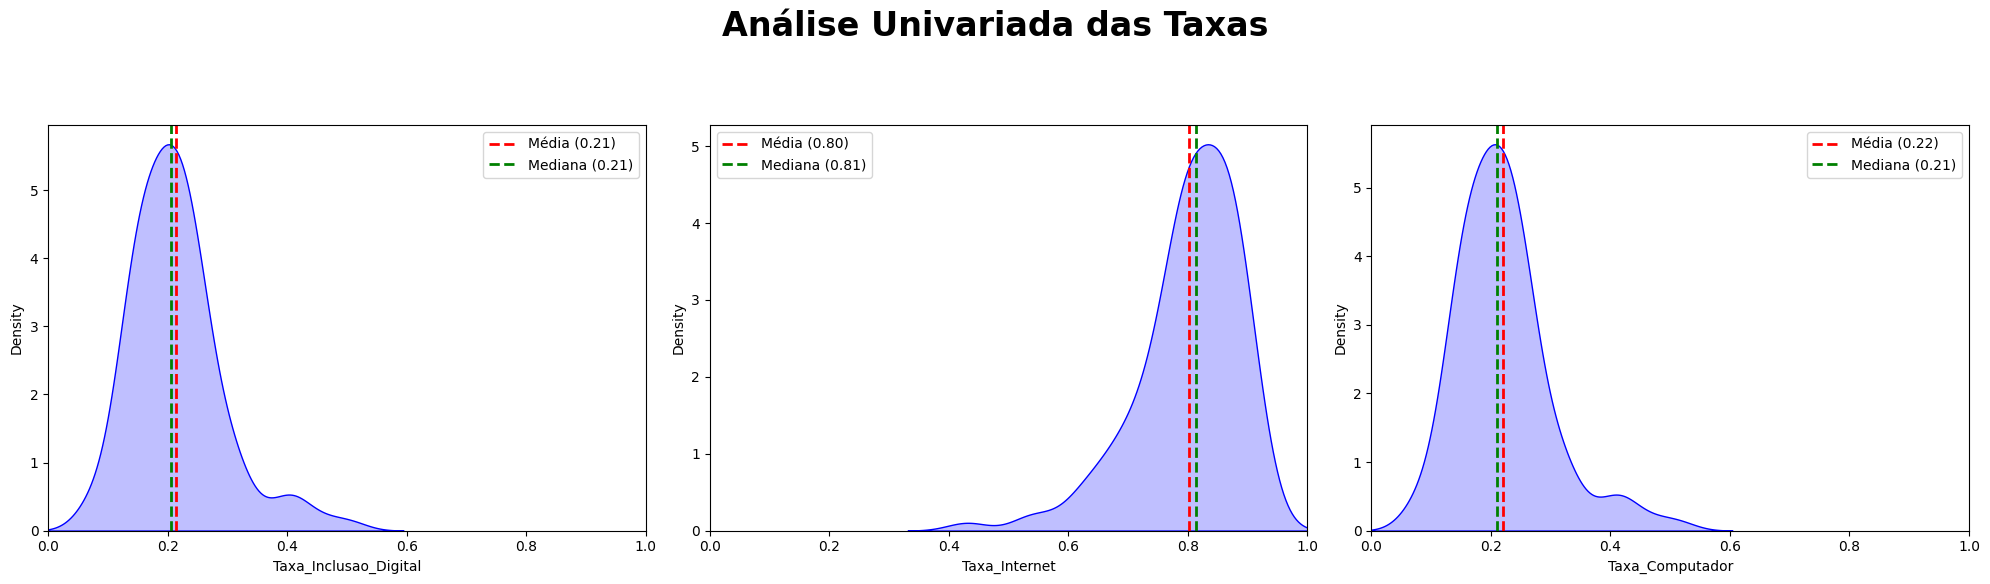

In [23]:
plt.figure(figsize=(20, 26))

# Título central ajustado para não colidir com os subplots
plt.suptitle(
    "Análise Univariada das Taxas",
    fontsize=24,
    fontweight='bold',
    y=0.92   # <-- posição mais alta, acima dos gráficos
)

numeric_features = ['Taxa_Inclusao_Digital', 'Taxa_Internet', 'Taxa_Computador']

for i, feature in enumerate(numeric_features):
    plt.subplot(5, 3, i+1)

    # KDE
    sns.kdeplot(
        data=df_indicadores_mun24,
        x=feature,
        fill=True,
        color='blue'
    )

    # Média e mediana
    media = df_indicadores_mun24[feature].mean()
    mediana = df_indicadores_mun24[feature].median()

    plt.axvline(media, color='red', linestyle='--', linewidth=2,
                label=f"Média ({media:.2f})")
    plt.axvline(mediana, color='green', linestyle='--', linewidth=2,
                label=f"Mediana ({mediana:.2f})")

    plt.xlabel(feature)
    plt.xlim(0, 1)
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # <-- reserva espaço p/ o título

plt.show()


In [24]:
df_indicadores_mun.sort_values(by=['Taxa_Inclusao_Digital'], ascending=False)

,NO_MUNICIPIO_PROVA,Total_Alunos,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Taxa_Alunos
39,Fortaleza,71173,34669,0.487109,56844,0.798674,35946,0.505051,614.834558,523.902734,543.529739,533.426242,489.605600,541.059775,0.321607
63,Juazeiro do Norte,8203,3918,0.477630,6538,0.797025,4134,0.503962,612.614897,505.058771,529.524235,520.468536,477.388358,529.010959,0.037067
34,Crato,3592,1710,0.476058,2839,0.790367,1793,0.499165,613.814031,508.147049,525.353814,520.734243,479.897272,529.589282,0.016231
13,Barbalha,1840,848,0.460870,1429,0.776630,887,0.482065,591.141304,496.852391,516.506848,512.565054,474.058315,518.224783,0.008314
107,Tabuleiro do Norte,980,428,0.436735,785,0.801020,446,0.455102,578.714286,493.141327,514.344592,509.829082,469.243980,513.054653,0.004428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Pacoti,930,125,0.134409,364,0.391398,150,0.161290,534.086022,477.396667,476.996237,495.092258,440.481613,484.810559,0.004202
114,Uruburetama,1259,154,0.122319,352,0.279587,195,0.154885,511.119936,472.365766,486.074424,490.459095,445.280620,481.059968,0.005689
88,Paraipaba,1040,124,0.119231,290,0.278846,143,0.137500,534.134615,481.023942,507.023654,496.227308,454.955769,494.673058,0.004699
110,Tejuçuoca,508,48,0.094488,193,0.379921,53,0.104331,511.338583,468.959252,493.403346,485.488189,437.283661,479.294606,0.002295


In [25]:
df_indicadores_mun24.sort_values(by=['Taxa_Inclusao_Digital'], ascending=False)

,NO_MUNICIPIO_PROVA,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Total_Alunos,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Taxa_Alunos
1,Eusébio,666.740548,525.507366,559.525163,538.279596,507.755671,559.561669,2185,1105,0.505721,2033,0.930435,1123,0.513959,0.008719
0,Fortaleza,668.456779,531.157742,555.222515,537.999137,508.354819,560.238198,73356,34070,0.464447,63061,0.859657,34719,0.473295,0.292713
3,Juazeiro do Norte,665.648267,520.104735,543.445999,530.034189,497.468664,551.340371,9849,4205,0.426947,8610,0.874200,4288,0.435374,0.039301
2,Sobral,655.898193,519.152232,557.991073,528.540539,497.097492,551.735906,7187,2965,0.412550,6438,0.895784,3006,0.418255,0.028678
4,Limoeiro do Norte,668.751381,514.498729,541.825856,524.151878,497.044862,549.254541,2389,963,0.403098,2129,0.891168,981,0.410632,0.009533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Paraipaba,624.791929,493.910340,525.827995,509.700000,478.497856,526.545624,1022,115,0.112524,615,0.601761,120,0.117417,0.004078
110,Orós,531.343284,474.511443,490.222886,497.963682,461.271891,491.062637,477,47,0.098532,301,0.631027,50,0.104822,0.001903
117,Pacoti,556.913580,452.636420,474.692469,474.669877,451.200123,482.022494,1012,87,0.085968,816,0.806324,91,0.089921,0.004038
106,Itatira,612.263868,449.687856,486.016492,470.842879,448.027136,493.367646,836,61,0.072967,602,0.720096,65,0.077751,0.003336


#### Correlação mudando

- "Em 2019, o 'Filtro Social' barrava o aluno na conexão (Internet). Quem passava pela barreira da internet, tinha chance.

- Em 2024, o filtro mudou de lugar. A porteira da internet foi aberta (correlação baixa), mas uma nova barreira, mais alta e rígida, foi erguida: a do Hardware (Computador).

Nossa métrica de Inclusão Digital Plena é robusta porque ela identifica exatamente quem conseguiu pular esse novo muro. Ela limpa o ruído do 'falso incluído' (o aluno que só tem celular) e foca no aluno que realmente tem estrutura de estudo."

In [26]:
print("2019")
display(df_indicadores_mun[['Taxa_Computador', 'Nota_Media_Geral']].corr())
display(df_indicadores_mun[['Taxa_Internet', 'Nota_Media_Geral']].corr())
print("\n")
print("2024")
display(df_indicadores_mun24[['Taxa_Computador', 'Nota_Media_Geral']].corr())
display(df_indicadores_mun24[['Taxa_Internet', 'Nota_Media_Geral']].corr())


2019


,Taxa_Computador,Nota_Media_Geral
Taxa_Computador,1.000000,0.724993
Nota_Media_Geral,0.724993,1.000000


,Taxa_Internet,Nota_Media_Geral
Taxa_Internet,1.000000,0.491553
Nota_Media_Geral,0.491553,1.000000




2024


,Taxa_Computador,Nota_Media_Geral
Taxa_Computador,1.000000,0.734011
Nota_Media_Geral,0.734011,1.000000


,Taxa_Internet,Nota_Media_Geral
Taxa_Internet,1.000000,0.289767
Nota_Media_Geral,0.289767,1.000000


#### Municípios que precisam de ajuda

In [27]:
p25 = np.percentile(df_indicadores_mun24['Taxa_Inclusao_Digital'], 25)
df24_sos = df_indicadores_mun24[df_indicadores_mun24['Taxa_Inclusao_Digital'] <= p25]
df24_sos

,NO_MUNICIPIO_PROVA,Nota_Redacao,Nota_CH,Nota_Mat,Nota_LC,Nota_CN,Nota_Media_Geral,Total_Alunos,Total_Inclusao_Digital,Taxa_Inclusao_Digital,Internet,Taxa_Internet,Computador,Taxa_Computador,Taxa_Alunos
19,Mulungu,657.600000,496.381600,508.390800,508.920800,475.695200,529.397680,315,42,0.133333,174,0.552381,42,0.133333,0.001257
23,Canindé,633.329596,497.809417,525.296917,512.482679,470.030998,527.789922,2448,294,0.120098,1645,0.671977,313,0.127859,0.009768
25,Paraipaba,624.791929,493.910340,525.827995,509.700000,478.497856,526.545624,1022,115,0.112524,615,0.601761,120,0.117417,0.004078
38,Jaguaruana,620.764192,486.417249,516.794323,504.636681,472.778930,520.278275,1253,165,0.131684,790,0.630487,172,0.137271,0.005000
56,Chaval,610.571429,486.246857,497.419429,505.632571,465.088000,512.991657,431,63,0.146172,330,0.765661,64,0.148492,0.001720
65,Viçosa do Ceará,599.752358,482.289741,502.473762,499.496816,466.202123,510.042960,2140,317,0.148131,1424,0.665421,332,0.155140,0.008539
67,Barroquinha,602.550725,483.375942,499.408406,501.083188,461.904058,509.664464,476,69,0.144958,374,0.785714,74,0.155462,0.001899
75,Trairi,598.775194,475.858295,505.966202,496.539535,463.543876,508.136620,1577,228,0.144578,1265,0.802156,239,0.151554,0.006293
78,Aracoiaba,604.935345,472.254741,502.024353,492.641272,458.461746,506.063491,1119,178,0.159071,871,0.778374,182,0.162645,0.004465
82,Pindoretama,589.891697,473.967329,497.451444,498.972563,464.423105,504.941227,716,101,0.141061,565,0.789106,105,0.146648,0.002857


#### Relação entre variação da taxa e variação de alunos

In [29]:
df_merge = pd.merge(df_indicadores_mun, df_indicadores_mun24, how='left' ,
                    on='NO_MUNICIPIO_PROVA',
                    suffixes=('_19', '_24'))


C:\Users\139595\AppData\Local\Temp\ipykernel_14844\3704735688.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])


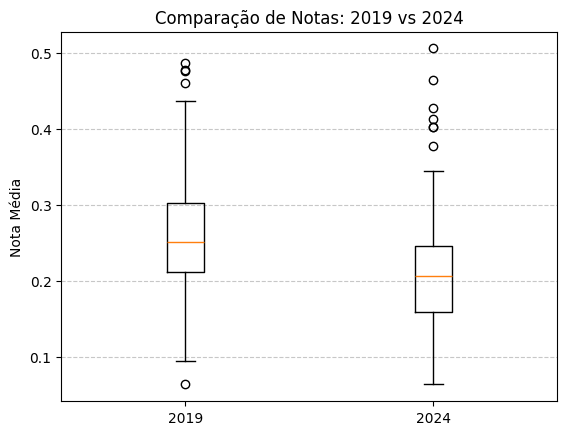

C:\Users\139595\AppData\Local\Temp\ipykernel_14844\3704735688.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])


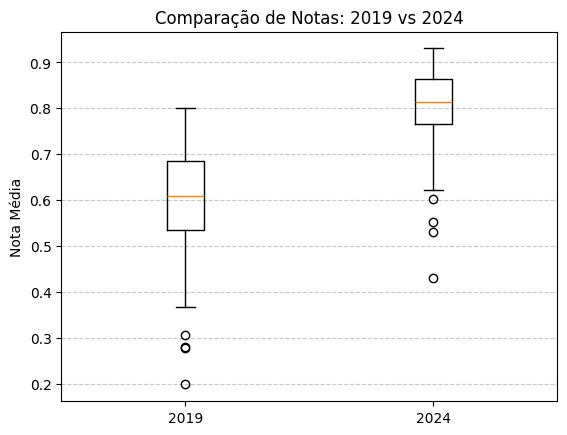

C:\Users\139595\AppData\Local\Temp\ipykernel_14844\3704735688.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])


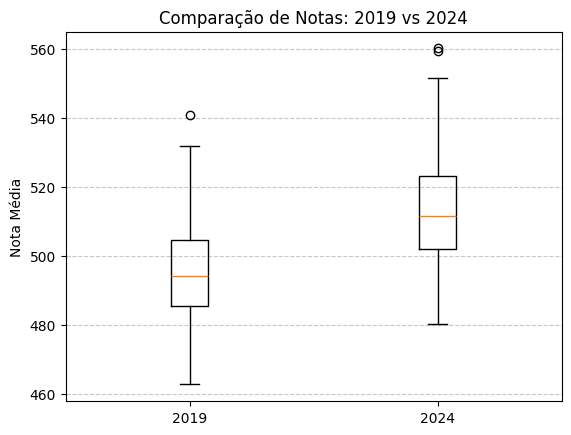

In [85]:

for i in ['Taxa_Inclusao_Digital','Taxa_Internet', 'Nota_Media_Geral']:
  # Seus dados
  data_group1 = df_indicadores_mun[i]
  # Nota: Para boxplot, os grupos NÃO precisam ter o mesmo tamanho.
  # Você não precisa cortar o group2 para ficar igual ao group1 se não quiser.
  data_group2 = df_indicadores_mun24[i]

  # CORREÇÃO: Coloque-os dentro de uma lista [a, b]
  data = [data_group1, data_group2]

  # Agora vai funcionar
  plt.boxplot(data, positions=[1, 2], labels=['2019', '2024'])
  plt.title('Comparação de Notas: 2019 vs 2024')
  plt.ylabel('Nota Média')
  plt.grid(True, axis='y', linestyle='--', alpha=0.7) # Dica extra: fica mais fácil de ler
  plt.show()

# Hipótese IA Generativa e Redação
Queremos propor a hipótese de que houve uma melhora no desempenho dos alunos em redação por conta da chegada da IA generativa, dado que esta é nativamente linguística. Com isso, aliado à conectividade facilitaria ainda mais o desempenho dos alunos, independente do dispositivo utilizado, o que poderia explicar parte da melhora das notas, apesar da queda da inclusão digital, alavancada pela falta de dispositivos como computadores e notebook

- Elaborar gráfico comparando as taxas analisadas num gráfico de barras
- Elaborar gráfico comparando as variações percentuais de um ano pra outro das notas do ENEM, e checar se redação possui um aumento maior

In [52]:
def grafico_comparativo(df_indicadores_mun, df_indicadores_mun24, notas = False):
  df_final = pd.merge(
    df_indicadores_mun[['NO_MUNICIPIO_RESIDENCIA', 'Taxa_Inclusao_Digital', 'Taxa_Computador', 'Taxa_Internet', 'Nota_Media_Geral', 'Nota_Redacao','Nota_CH', 'Nota_Mat', 'Nota_CN', 'Nota_LC', 'Total_Alunos']],
    df_indicadores_mun24[['NO_MUNICIPIO_PROVA', 'Taxa_Inclusao_Digital', 'Taxa_Computador', 'Taxa_Internet', 'Nota_Media_Geral', 'Nota_Redacao','Nota_CH', 'Nota_Mat', 'Nota_CN', 'Nota_LC','Total_Alunos']],
    right_on='NO_MUNICIPIO_PROVA',
    left_on='NO_MUNICIPIO_RESIDENCIA',
    suffixes=('_2019', '_2024'))
  
  # condicionar flag notas
  if notas:
    metricas = {
    'Nota_Media_Geral': 'Nota Média',
    'Nota_Redacao': 'Nota Redação',
    'Nota_CH': 'Nota CH',
    'Nota_LC': 'Nota LC',
    'Nota_CN': 'Nota CN',
    'Nota_Mat': 'Nota Mat',

    }
    
  else:
    metricas = {
    'Taxa_Inclusao_Digital': 'Taxa Inclusão Digital',
    'Taxa_Computador': 'Taxa Computador',
    'Taxa_Internet': 'Taxa Internet',
    'Total_Alunos': 'Total de Alunos (Média Mun.)'}


  dados_resumo = []
  # criar tabela de resumo
  for metrica_db, metrica_nome in metricas.items():
      valor_19 = df_final[f'{metrica_db}_2019'].mean()
      valor_24 = df_final[f'{metrica_db}_2024'].mean()
      
      if metrica_db == 'Total_Alunos':
          valor_19 = df_final[f'{metrica_db}_2019'].sum()
          valor_24 = df_final[f'{metrica_db}_2024'].sum()
          metrica_nome = 'Total de Alunos (Soma Estado)'
      
      delta = valor_24 - valor_19
      var_pct = (delta / valor_19) * 100
      
      dados_resumo.append({
          'Indicador': metrica_nome,
          '2019': valor_19,
          '2024': valor_24,
          'Diferença': delta,
          'Variação (%)': var_pct
      })

  df_resumo_executivo = pd.DataFrame(dados_resumo)

  display(df_resumo_executivo) 

  # gerar gráfico
  df_plot = df_resumo_executivo[df_resumo_executivo['Indicador'] != 'Total de Alunos (Soma Estado)'].melt(
      id_vars='Indicador', 
      value_vars=['2019', '2024'], 
      var_name='Ano', 
      value_name='Valor'
  )

  plt.figure(figsize=(14, 9))
  grafico = sns.barplot(data=df_plot, x='Indicador', y='Valor', hue='Ano', palette=['gray', 'blue'])

  plt.title('Comparativo de Indicadores: 2019 vs 2024', fontsize=14)
  plt.ylabel('Taxa Média / Nota')
  plt.xticks(rotation=15)
  plt.legend(title='Ano')


  for container in grafico.containers:
      grafico.bar_label(container, fmt='%.2f', padding=3)

  plt.tight_layout()
  plt.show()


,Indicador,2019,2024,Diferença,Variação (%)
0,Taxa Inclusão Digital,0.264431,0.214464,-0.049968,-18.896266
1,Taxa Computador,0.283944,0.219900,-0.064044,-22.555149
2,Taxa Internet,0.601356,0.801192,0.199836,33.230813
3,Total de Alunos (Soma Estado),205062.000000,250607.000000,45545.000000,22.210356


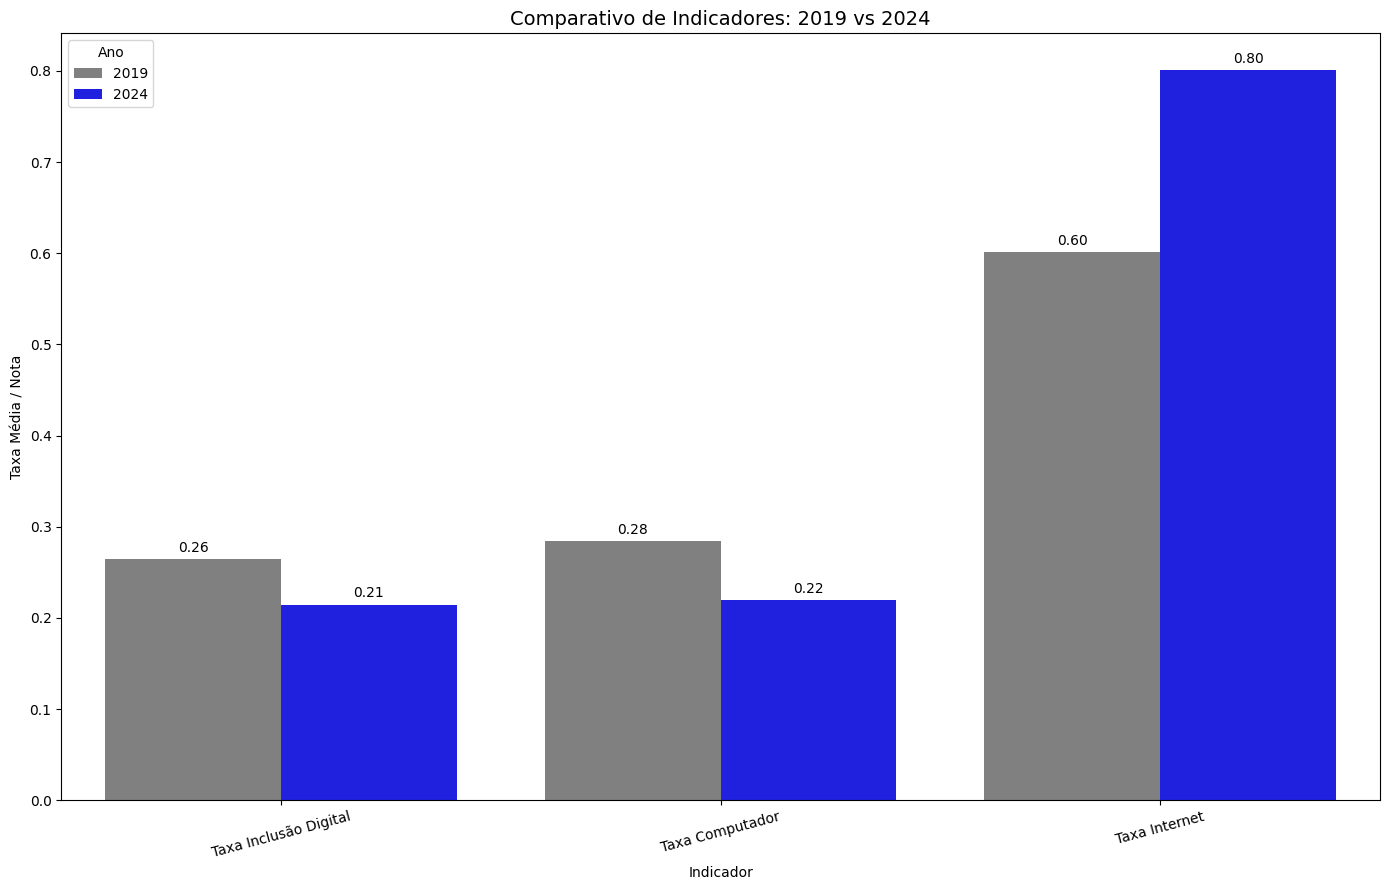

,Indicador,2019,2024,Diferença,Variação (%)
0,Nota Média,497.284015,513.742498,16.458483,3.309675
1,Nota Redação,545.596906,601.706399,56.109492,10.284056
2,Nota CH,484.512138,485.208357,0.696219,0.143695
3,Nota LC,500.407617,502.731409,2.323793,0.464380
4,Nota CN,454.359160,469.293367,14.934207,3.286873
5,Nota Mat,501.544255,509.772958,8.228703,1.640673


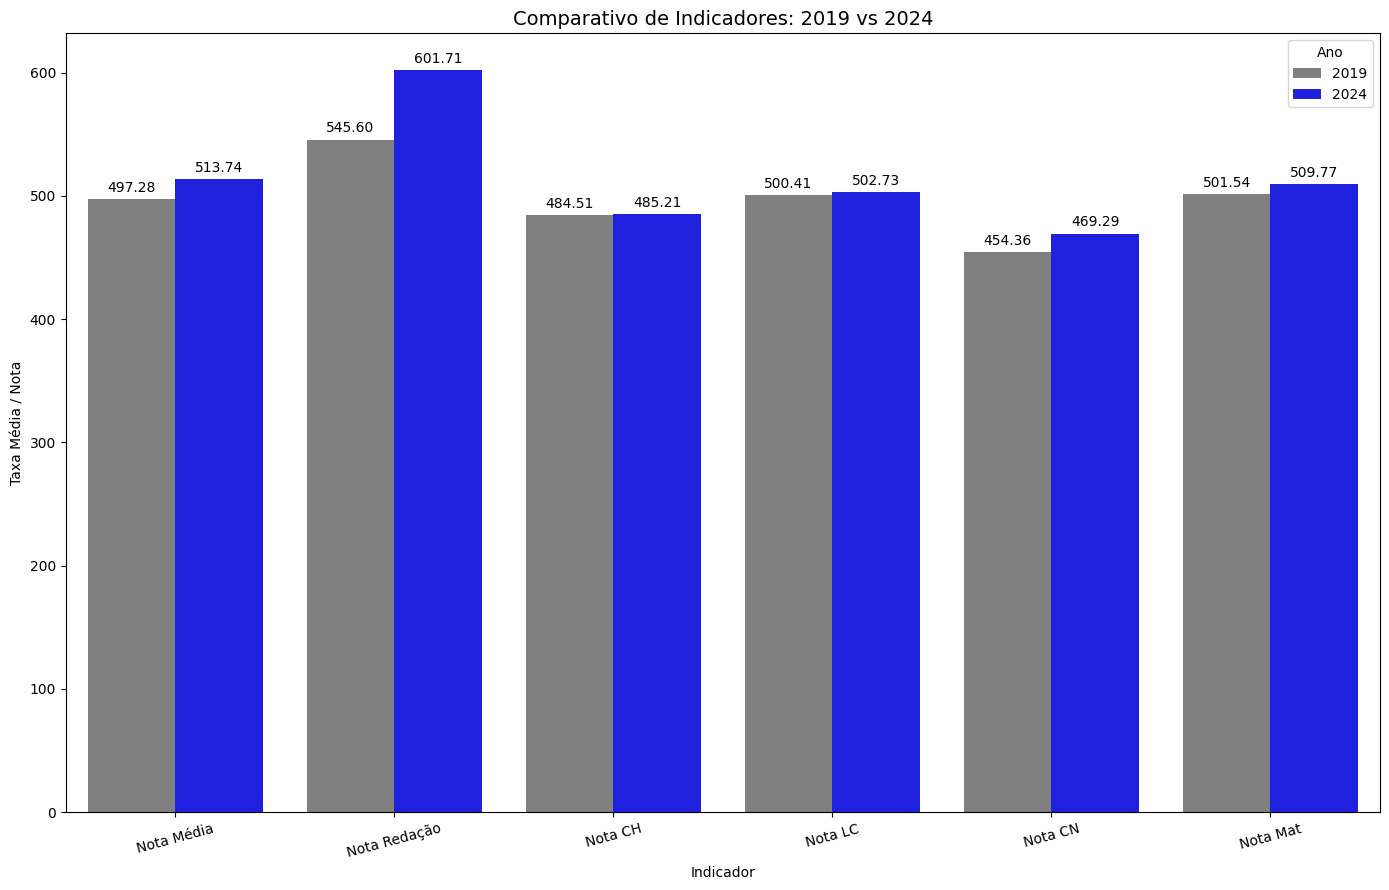

In [53]:
grafico_comparativo(df_indicadores_mun=df_indicadores_mun, df_indicadores_mun24=df_indicadores_mun24, notas = 0)
print("\n\n\n\n")
grafico_comparativo(df_indicadores_mun=df_indicadores_mun, df_indicadores_mun24=df_indicadores_mun24, notas = 1)


## Salvar dados

In [55]:
df_indicadores_mun.to_csv('indicadores19.csv')
df_indicadores_mun24.to_csv('indicadores24.csv')

# Causal Inference

O Problema: A simples diferença de médias diz que quem tem internet tira X pontos a mais. Isso é verdade ou é apenas reflexo da riqueza?

A Metodologia: Usamos Inferência Causal para simular o contrafactual (O aluno com internet, caso não a tivesse).

O Resultado (ATT): "Corrigindo pelo viés socioeconômico, a internet agrega X pontos na média."

O Insight (CATE): "Entretanto, para alunos de baixa renda, a internet tem um impacto Y% maior do que para alunos de alta renda."

In [ ]:
colunas_interesse = [
    'NU_INSCRICAO', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'SG_UF_RESIDENCIA', 
    'TP_ESCOLA', 'IN_TREINEIRO',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 
    'TP_STATUS_REDACAO',
    'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'SG_UF_PROVA', 'NO_MUNICIPIO_PROVA'
]

In [ ]:
df = df_raw[colunas_interesse]

In [ ]:
df = df[
  (df['SG_UF_RESIDENCIA'] == 'CE') & (df['NO_MUNICIPIO_PROVA'] != 'Fortaleza')
   ]

In [ ]:
df['NU_NOTA_GERAL'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT'] + df['NU_NOTA_REDACAO']) / 5


In [ ]:
df['Computador e Internet'] = np.where(
  (df['Q025'] == 'B') & (df['Q024'] != "A"),1, 0
)

In [ ]:
df['Computador'] = np.where(
  (df['Q025'] == 'B'),1, 0
)

In [ ]:
df['Computador'].value_counts(normalize=True)

Computador
1    0.620751
0    0.379249
Name: proportion, dtype: float64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(df['Q001'])
df['Q001_encoded'] = le.transform(df['Q001'])
# Criar uma nova coluna chamada 'Q006_encoded' no DataFrame df
le.fit(df['Q006'])
df['Q006_encoded'] = le.transform(df['Q006'])


In [ ]:
# Lista de variáveis a serem convertidas
confundidores = [
    'Q006', 'Q001', 'Q002', 'TP_ESCOLA', 'TP_COR_RACA', 
    'NU_IDADE', 'SG_UF_RESIDENCIA'
]

# Converter cada variável para numérica (exceto NU_IDADE que já é numérica)
for coluna in confundidores:
    if coluna in df.columns:
        if coluna != 'NU_IDADE':  # Pula a coluna de idade
            df[coluna] = pd.factorize(df[coluna])[0]  # Converte categorias em códigos numéricos
    else:
        print(f"Aviso: Coluna '{coluna}' não encontrada no DataFrame.")

# Verificar os tipos de dados resultantes
df

,NU_INSCRICAO,NU_IDADE,TP_SEXO,TP_COR_RACA,SG_UF_RESIDENCIA,TP_ESCOLA,IN_TREINEIRO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,...,Q006,Q024,Q025,SG_UF_PROVA,NO_MUNICIPIO_PROVA,NU_NOTA_GERAL,Computador e Internet,Computador,Q001_encoded,Q006_encoded
73,190001133213,26.0,M,0,0,0,0,0,0,0,...,0,B,B,CE,Juazeiro do Norte,NaN,1,1,4,3
90,190001133215,23.0,M,0,0,1,0,0,0,0,...,1,A,A,CE,Juazeiro do Norte,NaN,0,0,1,0
126,190001133216,24.0,F,1,0,1,0,0,0,0,...,0,B,B,CE,Quixeramobim,NaN,1,1,0,3
193,190001133218,21.0,F,2,0,1,0,1,1,1,...,2,A,B,CE,Eusébio,583.82,0,1,1,1
195,190001133220,22.0,M,2,0,1,0,0,0,0,...,2,B,B,CE,Tauá,NaN,1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5095133,190005703237,35.0,M,0,0,1,0,1,1,1,...,6,B,B,CE,Crateús,646.72,1,1,1,7
5095136,190005703238,18.0,M,4,0,0,0,0,0,0,...,2,A,A,CE,Juazeiro do Norte,NaN,0,0,7,1
5095179,190005703239,33.0,M,1,0,1,0,1,1,1,...,3,B,B,CE,Quixeramobim,443.48,1,1,0,2
5095217,190005701188,19.0,M,0,0,1,0,0,0,0,...,3,B,B,CE,Barreira,NaN,1,1,6,2


In [ ]:
# Definindo os limites (ex: 5% e 95%)
min_ps = 0.05
max_ps = 0.87



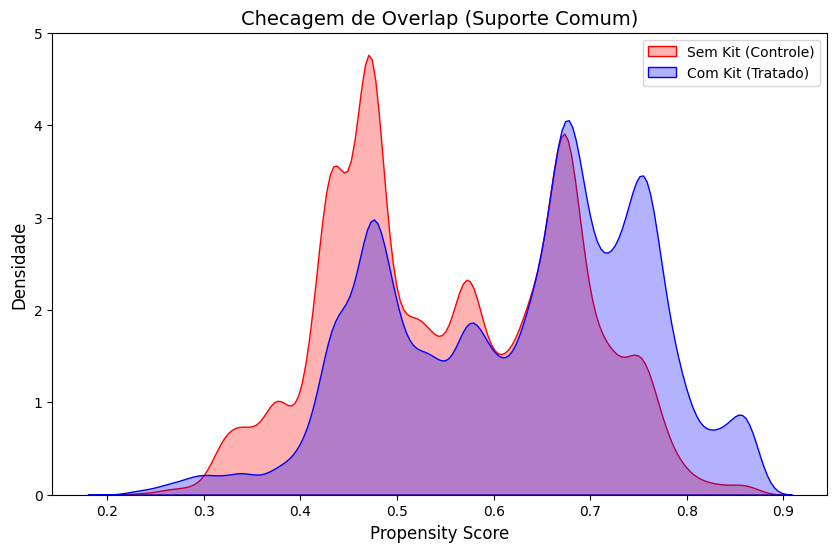

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Defina seus Confundidores (X) e Tratamento (T)
# Adicione aqui todas as variáveis que causam T e Y (ex: Renda, Escolaridade Mãe, Tipo Escola, Raça)
# IMPORTANTE: As variáveis categóricas devem estar codificadas (Get Dummies ou LabelEncoder)
# confundidores = ['Q006_encoded', 'Q001_encoded', 'TP_ESCOLA', 'NU_NOTA_CH', 'NU_NOTA_LC'] # Exemplo
X = df[confundidores].fillna(0) # Trate nulos antes
T = df['Computador'] # Sua variável binária criada

# 2. Calcule o Propensity Score
# Usamos Logistic Regression para estimar P(T=1 | X)
clf = LogisticRegression(solver='liblinear', random_state=42)
clf.fit(X, T)
ps_score = clf.predict_proba(X)[:, 1] # Pega a prob da classe 1

# Adiciona ao dataframe para plotar
df['ps_score'] = ps_score

# Filtrando o dataframe (Trimming)
df_trim = df[
    (df['ps_score'] >= min_ps) & 
    (df['ps_score'] <= max_ps)
]

# 3. Plote o Gráfico
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_trim[df_trim['Computador'] == 0], x='ps_score', fill=True, label='Sem Kit (Controle)', color='red', alpha=0.3)
sns.kdeplot(data=df_trim[df_trim['Computador'] == 1], x='ps_score', fill=True, label='Com Kit (Tratado)', color='blue', alpha=0.3)

plt.title('Checagem de Overlap (Suporte Comum)', fontsize=14)
plt.xlabel('Propensity Score', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()
plt.show()

In [ ]:

# Supondo que seu dataframe seja 'df' e já tenha as colunas:
# 'ps_score': o score que você gerou no gráfico
# 'Computador e Internet': seu T (0 ou 1)
# 'NU_NOTA_GERAL': sua variável Y (média das notas, ou a nota que vc quer analisar)

# 1. Definir limites de Trimming (Segurança Estatística)
# Vamos manter apenas alunos onde há disputa real entre ter e não ter o kit
min_score = 0.05
max_score = 0.95

mask_overlap = (df['ps_score'] >= min_score) & (df['ps_score'] <= max_score)
df_trimmed = df[mask_overlap].copy()

print(f"Linhas originais: {len(df)}")
print(f"Linhas após trimming: {len(df_trimmed)} (Perda segura para garantir robustez)")

# 2. Calcular os Pesos (Weights) para ATT
# Para quem TEM computador (T=1), o peso é 1.
# Para quem NÃO TEM (T=0), o peso é odds = PS / (1 - PS).
# Isso faz os "sem computador" que parecem ricos valerem por muitos.

df_trimmed['w_att'] = np.where(
    df_trimmed['Computador e Internet'] == 1,
    1,
    df_trimmed['ps_score'] / (1 - df_trimmed['ps_score'])
)

# 3. Calcular o Efeito Causal (Diferença de Médias Ponderada)
# Y1: Média ponderada dos Tratados
y1_w = np.average(df_trimmed.loc[df_trimmed['Computador e Internet']==1, 'NU_NOTA_GERAL'],
                  weights=df_trimmed.loc[df_trimmed['Computador e Internet']==1, 'w_att'])

# Y0: Média ponderada dos Controles (O Contrafactual!)
y0_w = np.average(df_trimmed.loc[df_trimmed['Computador e Internet']==0, 'NU_NOTA_GERAL'],
                  weights=df_trimmed.loc[df_trimmed['Computador e Internet']==0, 'w_att'])

att = y1_w - y0_w

# 4. Comparação "Naïve" (Ingênua - sem causalidade)
naive_diff = df_trimmed[df_trimmed['Computador e Internet']==1]['NU_NOTA_GERAL'].mean() - \
             df_trimmed[df_trimmed['Computador e Internet']==0]['NU_NOTA_GERAL'].mean()

print(f"\n--- RESULTADOS ---")
print(f"Diferença 'Ingênua' (Média simples): {naive_diff:.2f} pontos")
# print(f"ATT Estimado (Efeito Causal Real):   {att:.2f} pontos")
# print(f"Viés de Seleção removido:            {naive_diff - att:.2f} pontos")
print(y1_w)

Linhas originais: 201008
Linhas após trimming: 195843 (Perda segura para garantir robustez)

--- RESULTADOS ---
Diferença 'Ingênua' (Média simples): 52.53 pontos
nan
